# Bài thực hành: Unsupervised Domain Adaptation

In [1]:
import random
import os
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
from PIL import Image
import os
from torchvision import datasets
from torchvision import transforms
from torchsummary import summary

# Tạo dataloader

In [2]:
class GetLoader(torch.utils.data.Dataset):
    def __init__(self, data_root, data_list, transform=None):
        self.root = data_root
        self.transform = transform

        f = open(data_list, 'r')
        data_list = f.readlines()
        f.close()

        self.n_data = len(data_list)

        self.img_paths = []
        self.img_labels = []

        for data in data_list:
            self.img_paths.append(data[:-3])
            self.img_labels.append(data[-2])

    def __getitem__(self, item):
        img_paths, labels = self.img_paths[item], self.img_labels[item]
        imgs = Image.open(os.path.join(self.root, img_paths)).convert('RGB')

        if self.transform is not None:
            imgs = self.transform(imgs)
            labels = int(labels)

        return imgs, labels

    def __len__(self):
        return self.n_data

# Tạo lớp reverse layer
Thêm hệ số $\alpha$ vào reversed gradient

In [3]:
from torch.autograd import Function

class ReverseLayerF(Function):

    @staticmethod
    def forward(ctx, x, alpha):
        ctx.alpha = alpha

        return x.view_as(x)

    @staticmethod
    def backward(ctx, grad_output):
        output = grad_output.neg() * ctx.alpha

        return output, None

# Mô hình chính
Tương tự mô hình CNN bình thường nhưng thêm bộ phân loại miền dữ liệu:
- Bộ trích xuất đặc trưng: $G_f$
- Bộ phân loại nhãn của dữ liệu nguồn: $G_y$
- Bộ phân loại miền dữ liệu (nguồn hay đích): $G_d$

In [ ]:
import torch.nn as nn

class CNNModel(nn.Module):

    def __init__(self):
        super(CNNModel, self).__init__()

        # Đây là phần feature extracter (encoder/backbone)
        self.feature = nn.Sequential()
        self.feature.add_module('f_conv1', nn.Conv2d(3, 64, kernel_size=5))
        self.feature.add_module('f_bn1', nn.BatchNorm2d(64))
        self.feature.add_module('f_pool1', nn.MaxPool2d(2))
        self.feature.add_module('f_relu1', nn.ReLU(True))
        self.feature.add_module('f_conv2', nn.Conv2d(64, 50, kernel_size=5))
        self.feature.add_module('f_bn2', nn.BatchNorm2d(50))
        self.feature.add_module('f_drop1', nn.Dropout2d())
        self.feature.add_module('f_pool2', nn.MaxPool2d(2))
        self.feature.add_module('f_relu2', nn.ReLU(True))

        # Xây dựng bộ phân lớp chữ số gồm các lớp sau với số lượng tham số như summary phía dưới
        # FC 100 -> BN -> ReLU -> Dropout -> FC 100 -> BN -> ReLU -> FC 10 -> LogSoftmax
        self.class_classifier = nn.Sequential()
        
        ######################
        ### YOUR CODE HERE ###
        ######################

        # Xây dựng bộ phân lớp miền gồm các lớp sau với số lượng tham số như summary phía dưới
        # FC 100 -> BN -> ReLU -> FC 2 -> LogSoftmax 
        self.domain_classifier = nn.Sequential()

        ######################
        ### YOUR CODE HERE ###
        ######################

    def forward(self, input_data, alpha=0):
        input_data = input_data.expand(input_data.data.shape[0], 3, 28, 28)
        feature = self.feature(input_data)
        feature = feature.view(-1, 50 * 4 * 4)
        reverse_feature = ReverseLayerF.apply(feature, alpha)
        class_output = ### YOUR CODE HERE ###
        domain_output = ### YOUR CODE HERE ###

        return class_output, domain_output

# D = CNNModel().cuda()
# summary(D, [(3,28,28)], batch_size=-1)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 24, 24]           4,864
       BatchNorm2d-2           [-1, 64, 24, 24]             128
         MaxPool2d-3           [-1, 64, 12, 12]               0
              ReLU-4           [-1, 64, 12, 12]               0
            Conv2d-5             [-1, 50, 8, 8]          80,050
       BatchNorm2d-6             [-1, 50, 8, 8]             100
         Dropout2d-7             [-1, 50, 8, 8]               0
         MaxPool2d-8             [-1, 50, 4, 4]               0
              ReLU-9             [-1, 50, 4, 4]               0
           Linear-10                  [-1, 100]          80,100
      BatchNorm1d-11                  [-1, 100]             200
             ReLU-12                  [-1, 100]               0
        Dropout2d-13                  [-1, 100]               0
           Linear-14                  [

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


# Tải và trực quan hoá dữ liệu


## Đầu tiên chúng ta tải dữ liệu MNIST và MNISTM:

In [4]:
!curl -L -c cookies.txt 'https://docs.google.com/uc?export=download&id=0B_tExHiYS-0veklUZHFYT19KYjg'| sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1/p' > confirm.txt
!curl -L -b cookies.txt -o mnist_m.tar.gz 'https://docs.google.com/uc?export=download&id=0B_tExHiYS-0veklUZHFYT19KYjg&confirm='$(<confirm.txt)
#!wget http://112.78.4.106/mnist_m.tar.gz
!rm -f confirm.txt cookies.txt

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  2254    0  2254    0     0   1599      0 --:--:--  0:00:01 --:--:--  1599
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  127M  100  127M    0     0   101M      0  0:00:01  0:00:01 --:--:--  311M


In [ ]:
#backup link

#!curl -L -c cookies.txt 'https://drive.google.com/uc?export=download&id=1YHGhEQVEJ9glB-KfMdvztVVZ-cMLrxOU'| sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1/p' > confirm.txt
#!curl -L -b cookies.txt -o mnist_m.tar.gz 'https://drive.google.com/uc?export=download&id=1YHGhEQVEJ9glB-KfMdvztVVZ-cMLrxOU&confirm='$(<confirm.txt)
#!rm -f confirm.txt cookies.txt

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  2262    0  2262    0     0  19842      0 --:--:-- --:--:-- --:--:-- 19842
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  179M  100  179M    0     0  76.6M      0  0:00:02  0:00:02 --:--:-- 88.4M


In [5]:
!mkdir -p dataset
!mkdir -p models
!mv mnist_m.tar.gz dataset
!cd dataset && tar -xvf mnist_m.tar.gz > /dev/null

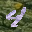

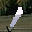

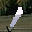

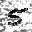

In [6]:
from IPython.display import Image, display

list_imgs = ['dataset/mnist_m/mnist_m_test/00008264.png', 'dataset/mnist_m/mnist_m_test/00005093.png',
            'dataset/mnist_m/mnist_m_test/00005093.png', 'dataset/mnist_m/mnist_m_test/00005222.png']

for img_name in list_imgs:
    display(Image(filename=img_name))

In [7]:
from PIL import Image

source_dataset_name = 'MNIST'
target_dataset_name = 'mnist_m'
source_image_root = os.path.join('dataset', source_dataset_name)
target_image_root = os.path.join('dataset', target_dataset_name)
model_root = 'models'
cuda = True
cudnn.benchmark = True
lr = 1e-3
batch_size = 128
image_size = 28
n_epoch = 100

try:
    num_workers = int(os.popen('nproc').read())
except:
    num_workers = 4

manual_seed = random.randint(1, 10000)
random.seed(manual_seed)
torch.manual_seed(manual_seed)
# load data

img_transform_source = transforms.Compose([
    transforms.Resize(image_size),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.1307,), std=(0.3081,))
])

img_transform_target = transforms.Compose([
    transforms.Resize(image_size),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
])

dataset_source = datasets.MNIST(
    root='dataset',
    train=True,
    transform=img_transform_source,
    download=True
)

dataloader_source = torch.utils.data.DataLoader(
    dataset=dataset_source,
    batch_size=batch_size,
    shuffle=True,
    num_workers=8)

train_list = os.path.join(target_image_root, 'mnist_m_train_labels.txt')
dataset_target = GetLoader(
    data_root=os.path.join(target_image_root, 'mnist_m_train'),
    data_list=train_list,
    transform=img_transform_target
)

dataloader_target = torch.utils.data.DataLoader(
    dataset=dataset_target,
    batch_size=batch_size,
    shuffle=True,
    num_workers=8)


  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting dataset/MNIST/raw/train-images-idx3-ubyte.gz to dataset/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting dataset/MNIST/raw/train-labels-idx1-ubyte.gz to dataset/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting dataset/MNIST/raw/t10k-images-idx3-ubyte.gz to dataset/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting dataset/MNIST/raw/t10k-labels-idx1-ubyte.gz to dataset/MNIST/raw



/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [8]:
dataset_source[0]

(tensor([[[-0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
           -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
           -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
           -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
           -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
           -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
           -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
           -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
           -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
           -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242],
          [-0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
           -0.4242, -0.4242, -0.424

# Tạo một đối tượng model cụ thể và optimizer

In [ ]:

my_net = ### YOUR CODE HERE ###

# Khai báo optimizer Adam với tốc độ học là lr
optimizer = ### YOUR CODE HERE ###

# Khai báo hàm loss Negative log likelihood
loss_class = ### YOUR CODE HERE ###
loss_domain = ### YOUR CODE HERE ###

if cuda:
    my_net = my_net.cuda()
    loss_class = loss_class.cuda()
    loss_domain = loss_domain.cuda()

for p in my_net.parameters():
    p.requires_grad = True


# Hàm test

In [ ]:

def test(dataset_name, epoch):
    assert dataset_name in ['MNIST', 'mnist_m']

    model_root = 'models'
    image_root = os.path.join('dataset', dataset_name)

    cuda = True
    cudnn.benchmark = True
    batch_size = 128
    image_size = 28
    alpha = 0

    """load data"""

    img_transform_source = transforms.Compose([
        transforms.Resize(image_size),
        transforms.ToTensor(),
        transforms.Normalize(mean=(0.1307,), std=(0.3081,))
    ])

    img_transform_target = transforms.Compose([
        transforms.Resize(image_size),
        transforms.ToTensor(),
        transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
    ])

    if dataset_name == 'mnist_m':
        test_list = os.path.join(image_root, 'mnist_m_test_labels.txt')

        dataset = GetLoader(
            data_root=os.path.join(image_root, 'mnist_m_test'),
            data_list=test_list,
            transform=img_transform_target
        )
    else:
        dataset = datasets.MNIST(
            root='dataset',
            train=False,
            transform=img_transform_source,
        )

    dataloader = torch.utils.data.DataLoader(
        dataset=dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=8
    )

    """ training """

    my_net = torch.load(os.path.join(
        model_root, 'mnist_mnistm_model_epoch_' + str(epoch) + '.pth'
    ))
    my_net = my_net.eval()

    if cuda:
        my_net = my_net.cuda()

    len_dataloader = len(dataloader)
    data_target_iter = iter(dataloader)

    i = 0
    n_total = 0
    n_correct = 0

    while i < len_dataloader:

        # test model using target data
        data_target = data_target_iter.next()
        t_img, t_label = data_target

        batch_size = len(t_label)

        input_img = torch.FloatTensor(batch_size, 3, image_size, image_size)
        class_label = torch.LongTensor(batch_size)

        if cuda:
            t_img = t_img.cuda()
            t_label = t_label.cuda()
            input_img = input_img.cuda()
            class_label = class_label.cuda()

        input_img.resize_as_(t_img).copy_(t_img)
        class_label.resize_as_(t_label).copy_(t_label)

        class_output, _ = my_net(input_data=input_img, alpha=alpha)
        pred = class_output.data.max(1, keepdim=True)[1]
        n_correct += pred.eq(class_label.data.view_as(pred)).cpu().sum()
        n_total += batch_size

        i += 1

    accu = n_correct.data.numpy() * 1.0 / n_total

    print('epoch: %d, accuracy of the %s dataset: %f' % (epoch, dataset_name, accu))

# Huấn luyện mô hình

In [ ]:
import numpy as np


for epoch in range(n_epoch):

    len_dataloader = min(len(dataloader_source), len(dataloader_target))
    data_source_iter = iter(dataloader_source)
    data_target_iter = iter(dataloader_target)

    i = 0
    while i < len_dataloader:

        p = float(i + epoch * len_dataloader) / n_epoch / len_dataloader
        alpha = 2. / (1. + np.exp(-10 * p)) - 1

        # training model using source data
        data_source = data_source_iter.next()
        s_img, s_label = data_source

        my_net.zero_grad()
        batch_size = len(s_label)

        input_img = torch.FloatTensor(batch_size, 3, image_size, image_size)
        class_label = torch.LongTensor(batch_size)
        domain_label = torch.zeros(batch_size)
        domain_label = domain_label.long()

        if cuda:
            s_img = s_img.cuda()
            s_label = s_label.cuda()
            input_img = input_img.cuda()
            class_label = class_label.cuda()
            domain_label = domain_label.cuda()

        input_img.resize_as_(s_img).copy_(s_img)
        class_label.resize_as_(s_label).copy_(s_label)

        class_output, domain_output = my_net(input_data=input_img, alpha=alpha)

        # Tính toán hàm loss bằng cách so sánh class_output, domain_output với class_label và domain_label
        err_s_label = ### YOUR CODE HERE ###
        err_s_domain = ### YOUR CODE HERE ###

        # training model using target data
        data_target = data_target_iter.next()
        t_img, _ = data_target

        batch_size = len(t_img)

        input_img = torch.FloatTensor(batch_size, 3, image_size, image_size)
        domain_label = torch.ones(batch_size)
        domain_label = domain_label.long()

        if cuda:
            t_img = t_img.cuda()
            input_img = input_img.cuda()
            domain_label = domain_label.cuda()

        input_img.resize_as_(t_img).copy_(t_img)

        _, domain_output = my_net(input_data=input_img, alpha=alpha)

        # Khi dùng target domain ta không có nhãn phân lớp chữ số nên chỉ có loss phân lớp 2 miền nguồn/đích
        err_t_domain = ### YOUR CODE HERE ###

        # Loss chung cả mô hình là kết hợp các loss trên
        err = ### YOUR CODE HERE ###
        
        err.backward()
        optimizer.step()

        i += 1

        print('epoch: %d, [iter: %d / all %d], err_s_label: %f, err_s_domain: %f, err_t_domain: %f' \
              % (epoch, i, len_dataloader, err_s_label.cpu().data.numpy(),
                 err_s_domain.cpu().data.numpy(), err_t_domain.cpu().data.numpy()))

    torch.save(my_net, '{0}/mnist_mnistm_model_epoch_{1}.pth'.format(model_root, epoch))
    test(source_dataset_name, epoch)
    test(target_dataset_name, epoch)


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


epoch: 0, [iter: 1 / all 461], err_s_label: 2.356144, err_s_domain: 0.711266, err_t_domain: 0.738152
epoch: 0, [iter: 2 / all 461], err_s_label: 2.222595, err_s_domain: 0.690732, err_t_domain: 0.730389
epoch: 0, [iter: 3 / all 461], err_s_label: 2.210872, err_s_domain: 0.690987, err_t_domain: 0.723651
epoch: 0, [iter: 4 / all 461], err_s_label: 2.163066, err_s_domain: 0.699525, err_t_domain: 0.718134
epoch: 0, [iter: 5 / all 461], err_s_label: 2.031859, err_s_domain: 0.687801, err_t_domain: 0.720685
epoch: 0, [iter: 6 / all 461], err_s_label: 2.011601, err_s_domain: 0.689232, err_t_domain: 0.708959
epoch: 0, [iter: 7 / all 461], err_s_label: 1.955968, err_s_domain: 0.682398, err_t_domain: 0.717258
epoch: 0, [iter: 8 / all 461], err_s_label: 1.870084, err_s_domain: 0.667870, err_t_domain: 0.711373
epoch: 0, [iter: 9 / all 461], err_s_label: 1.792854, err_s_domain: 0.666925, err_t_domain: 0.722035
epoch: 0, [iter: 10 / all 461], err_s_label: 1.810228, err_s_domain: 0.660254, err_t_domain

KeyboardInterrupt: ignored